In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder2 import Autoencoder2, reduce_dimensions2
import torchvision
from model2 import classification_model
import copy
import partition
from pca import PCADigitReducer
from training import train,test, train_fashion,test_fashion
from federated_learning import distribute_global_model, federated_averaging
from model4 import MultilayerPerceptron
import cluster2
from sklearn.metrics import precision_score, recall_score, f1_score
import time

# Data Preprocessing

In [2]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01 # ev. 0.001
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
# training and testing data as dataloaders

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.0,), (1,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.0,), (1,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
train_loader_pca = copy.copy(train_loader)
test_loader_pca = copy.copy(test_loader)

train_loader_auto = copy.copy(train_loader)
test_loader_auto = copy.copy(test_loader)

In [5]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1] 

# Autoencoder

In [6]:
autoencoder2 = Autoencoder2()
auto2_criterion = nn.BCELoss()  
auto2_optimizer = optim.Adam(autoencoder2.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
num_epochs = 5 # optimal nach vielen testen
for epoch in range(num_epochs):
    autoencoder2.train()
    train_loss = 0

    for images, _ in train_loader_auto:
        images = images.to(device)

        auto2_optimizer.zero_grad()
        outputs = autoencoder2(images)
        loss = auto2_criterion(outputs, images) 
        
        loss.backward()
        auto2_optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader_auto)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

Epoch [1/5], Loss: 0.1123
Epoch [2/5], Loss: 0.0847
Epoch [3/5], Loss: 0.0806
Epoch [4/5], Loss: 0.0782
Epoch [5/5], Loss: 0.0767


# Experiment

In [ ]:
alpha = 10
num_clients = 10
num_clusters = [2, 4, 6, 8, 10]
results = {"classic": {}, "pca": {}, "autoencoder": {}}
clusteredResults = {"classic": {}, "pca": {}, "autoencoder": {}}

# Classic

In [13]:
# classic
trainingset = train_loader.dataset
trial_model = classification_model()
global_model_classic = classification_model()
rounds_classic = 4

In [ ]:
# Classic
partitioned_data_classic = partition.balanced_dirichlet_partition(
    trainingset, partitions_number=num_clients, alpha=alpha
)

classic_client_loaders = [
    DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_classic.values()
]


local_models_classic = [copy.deepcopy(global_model_classic) for _ in range(num_clients)]



for round_idx in range(rounds_classic):
    print(f"Round {round_idx + 1}/{rounds_classic}")
    t1 = time.time()

    local_weights_classic = []
    for client_idx, client_model in enumerate(local_models_classic):
        print(f"Training client {client_idx + 1}")

        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):
            train(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)

        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_classic.append(client_weights)

    global_weights_classic = federated_averaging(local_weights_classic)

    distribute_global_model(global_weights_classic, local_models_classic, single=False)
    distribute_global_model(global_weights_classic, global_model_classic, single=True)

    test_losses = []
    test(global_model_classic, test_loader, test_losses)
    t2= time.time()

    
    test_accuracies_classic = []
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            output = global_model_classic(data)
            pred = output.data.max(1, keepdim=True)[1]
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())
            correct += pred.eq(target.data.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracies_classic.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    
    results["classic"]["NoCluster"] = {"losses": [], "accuracy": [],"precision": [], "recall": [], "f1": [], "trainingTime": []}

    results["classic"]["NoCluster"]["losses"].extend(test_losses)
    results["classic"]["NoCluster"]["accuracy"].extend(test_accuracies_classic)
    results["classic"]["NoCluster"]["precision"].append(precision)
    results["classic"]["NoCluster"]["recall"].append(recall)
    results["classic"]["NoCluster"]["f1"].append(f1)
    results["classic"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################

for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_classic.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_classic)
    
    partitioned_data_classic_clustered = clustered_data

    """
    import cluster

    cluster = cluster.Cluster(num_clusters=num_cluster)

    targets = trainingset.targets
    num_classes = len(set(targets))
    clustered_data = cluster.apply_clustering(partitioned_data_classic, targets, num_classes)

    partitioned_data_classic_clustered = clustered_data
    """

    classic_client_loaders_clustered = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic_clustered.values()
    ]

    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")
        t1 = time.time()

        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic[0: num_cluster]):
            print(f"Training client {client_idx + 1}")

            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

            train_losses = []
            train_counter = []

            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, classic_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)

            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)

        global_weights_classic = federated_averaging(local_weights_classic)

        distribute_global_model(global_weights_classic, local_models_classic, single=False)
        distribute_global_model(global_weights_classic, global_model_classic, single=True)

        test_losses = []
        test(global_model_classic, test_loader, test_losses)
        t2= time.time()

        test_accuracies_classic = []
        correct = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in test_loader:
                output = global_model_classic(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
                correct += pred.eq(target.data.view_as(pred)).sum().item()

        accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracies_classic.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')

        # Save results for clustered classic
        if num_cluster not in clusteredResults["classic"]:
            clusteredResults["classic"][num_cluster] = {"losses": [], "accuracy": [],"precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["classic"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["classic"][num_cluster]["accuracy"].extend(test_accuracies_classic)
        clusteredResults["classic"][num_cluster]["precision"].append(precision)
        clusteredResults["classic"][num_cluster]["recall"].append(recall)
        clusteredResults["classic"][num_cluster]["f1"].append(f1)
        clusteredResults["classic"][num_cluster]["trainingTime"].append(t2-t1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.321489


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/60000 (1%)]	Loss: 2.286409
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.315170
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.299600
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.280446
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.314709
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.293261
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.324147
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.307605
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.299091
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.288186
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.287747
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.297445
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.303558
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.285877
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.291719
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.279933
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.300176
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.263024
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.270993
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.287440
Train Epoch: 1 [13440/60

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0822, Accuracy: 9739/10000 (97%)

Round 1/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 2.300503
Train Epoch: 1 [640/8115 (8%)]	Loss: 2.285187
Train Epoch: 1 [1280/8115 (16%)]	Loss: 2.247783
Train Epoch: 1 [1920/8115 (24%)]	Loss: 2.266890
Train Epoch: 1 [2560/8115 (31%)]	Loss: 2.249445
Train Epoch: 1 [3200/8115 (39%)]	Loss: 2.190974
Train Epoch: 1 [3840/8115 (47%)]	Loss: 2.250973
Train Epoch: 1 [4480/8115 (55%)]	Loss: 2.159498
Train Epoch: 1 [5120/8115 (63%)]	Loss: 2.137797
Train Epoch: 1 [5760/8115 (71%)]	Loss: 2.136161
Train Epoch: 1 [6400/8115 (79%)]	Loss: 2.153827
Train Epoch: 1 [7040/8115 (87%)]	Loss: 2.122877
Train Epoch: 1 [7680/8115 (94%)]	Loss: 2.165870
Train Epoch: 2 [0/8115 (0%)]	Loss: 2.067114
Train Epoch: 2 [640/8115 (8%)]	Loss: 1.964168
Train Epoch: 2 [1280/8115 (16%)]	Loss: 2.036886
Train Epoch: 2 [1920/8115 (24%)]	Loss: 1.848081
Train Epoch: 2 [2560/8115 (31%)]	Loss: 1.901126
Train Epoch: 2 [3200/8115 (39%)]	Loss: 1.758942
Train Epoch: 2

c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.716096
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.929674
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.689120
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.660290
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.693561
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.649931
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.607768
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.545482
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.840144
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.385750
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.580706
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.657949
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.478308
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.500162
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.727613
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.455859
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.429478
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.519249
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.379015
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.632968
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.388601


c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2486, Accuracy: 9318/10000 (93%)

Round 3/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.407769


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.301344
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.307228
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.473226
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.378357
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.399253
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.307462
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.204188
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.380448
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.392779
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.400549
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.365099
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.235876
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.439296
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.264754
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.220019
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.174437
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.689715
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.415409
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.271724
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.454587
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.266586


c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1661, Accuracy: 9488/10000 (95%)

Round 4/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.288428


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.282496
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.297242
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.415078
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.193273
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.233549
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.251726
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.448052
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.376582
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.226545
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.202535
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.266870
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.243929
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.160940
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.210680
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.541772
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.212190
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.292566
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.183909
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.229968
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.162387
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.241355


c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1340, Accuracy: 9576/10000 (96%)

Round 1/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.296361


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/31163 (2%)]	Loss: 0.347975
Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.307956
Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.213196
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.560513
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.197820
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.106902
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.304849
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.218829
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.230209
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.415283
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.431231
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.420057
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.360231
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.299127
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.251488
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.309795
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.240838
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.234775
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.221583
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.305552
Train Epoch: 1 [1344

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0792, Accuracy: 9747/10000 (97%)

Round 2/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.148470


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/31163 (2%)]	Loss: 0.076147
Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.128038
Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.134357
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.162150
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.227244
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.169067
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.139637
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.132666
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.411379
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.123027
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.170633
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.299401
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.195449
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.293010
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.295055
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.289455
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.190724
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.402819
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.279817
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.150588
Train Epoch: 1 [1344

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0660, Accuracy: 9782/10000 (98%)

Round 3/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.110231


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/31163 (2%)]	Loss: 0.090958
Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.161342
Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.081592
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.269672
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.179056
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.169567
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.123855
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.146142
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.187410
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.145416
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.218346
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.142583
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.097326
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.108770
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.245808
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.185484
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.163239
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.094794
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.080121
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.085267
Train Epoch: 1 [1344

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0559, Accuracy: 9824/10000 (98%)

Round 4/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.096924


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/31163 (2%)]	Loss: 0.071306
Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.162534
Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.129071
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.319238
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.336931
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.107418
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.147080
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.106261
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.381203
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.075474
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.105420
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.124724
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.097142
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.264154
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.259206
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.194134
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.174118
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.046915
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.138026
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.187122
Train Epoch: 1 [1344

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0477, Accuracy: 9846/10000 (98%)

Round 1/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.199593


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/19029 (3%)]	Loss: 0.257262
Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.091388
Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.126329
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.264300
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.225446
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.321236
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.116988
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.155703
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.077388
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.069475
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.146914
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.081116
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.235258
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.250307
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.353877
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.056426
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.087862
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.063978
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.103561
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.048510
Train Epoch: 1 [13

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0454, Accuracy: 9859/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.175919


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/19029 (3%)]	Loss: 0.055060
Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.082519
Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.098494
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.163854
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.181173
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.128317
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.184278
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.072201
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.285282
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.105161
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.111241
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.175952
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.098787
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.092314
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.099983
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.107651
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.198696
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.185675
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.083551
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.134817
Train Epoch: 1 [13

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0436, Accuracy: 9863/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.253452


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/19029 (3%)]	Loss: 0.137526
Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.055843
Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.048033
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.105629
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.144819
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.179847
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.170073
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.243906
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.074345
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.170197
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.058067
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.115698
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.222802
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.047727
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.029268
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.150452
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.057052
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.066239
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.030319
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.117792
Train Epoch: 1 [13

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0414, Accuracy: 9874/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.061696


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/19029 (3%)]	Loss: 0.184814
Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.040112
Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.109926
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.046567
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.207313
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.104809
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.056089
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.202972
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.023615
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.068678
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.162145
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.117396
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.256642
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.196250
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.274338
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.089758
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.026958
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.113759
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.083320
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.162819
Train Epoch: 1 [13

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0396, Accuracy: 9881/10000 (99%)

Round 1/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.096622


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11957 (5%)]	Loss: 0.143872
Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.026332
Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.022166
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.047839
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.071913
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.221397
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.125851
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.141838
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.065309
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.075849
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.107789
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.209672
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.089930
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.076043
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.121041
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.196380
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.043203
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.180352
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.038510
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.024343
Train Epoch: 2 [1280/1195

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0393, Accuracy: 9871/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.263613


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11957 (5%)]	Loss: 0.073109
Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.056331
Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.223375
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.060868
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.126569
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.148277
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.114037
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.102434
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.096466
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.072743
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.092270
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.128611
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.238119
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.138510
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.037979
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.176549
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.092812
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.022776
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.060953
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.057976
Train Epoch: 2 [1280/1195

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0383, Accuracy: 9882/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.186409
Train Epoch: 1 [640/11957 (5%)]	Loss: 0.040769


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.092039
Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.100587
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.069599
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.051754
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.042511
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.054785
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.203839
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.087879
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.057173
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.034834
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.153401
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.043132
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.222118
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.142633
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.026897
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.071019
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.136836
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.033595
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.027492
Train Epoch: 2 [1280/11957 (11%)]	Loss: 0.198025
Train Epoch: 2 [1920/11

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0376, Accuracy: 9879/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.039379


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11957 (5%)]	Loss: 0.235254
Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.063709
Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.165154
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.338721
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.083973
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.024057
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.087354
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.075414
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.052338
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.073904
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.199595
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.123176
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.046343
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.048388
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.105164
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.022096
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.040809
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.080602
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.078082
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.218450
Train Epoch: 2 [1280/1195

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0368, Accuracy: 9887/10000 (99%)

Round 1/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.208382


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.184327
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.086196
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.054904
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.262711
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.161100
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.068368
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.023652
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.032797
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.164955
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.200713
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.053642
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.160970
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.111652
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.091751
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.114613
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.129735
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.077289
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.040767
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.092677
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.054784
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.099244


c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0367, Accuracy: 9883/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.058797


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.049337
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.088872
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.023371
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.322736
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.081698
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.073039
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.037637
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.043783
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.091875
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.133402
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.091150
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.049769
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.147933
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.076530
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.186359
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.094673
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.075383
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.060218
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.096939
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.153560
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.207766


c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0356, Accuracy: 9886/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.157587


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.047820
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.035344
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.164255
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.046695
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.098894
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.173704
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.069026
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.091737
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.057749
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.227257
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.060875
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.120244
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.140895
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.125664
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.066849
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.134070
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.153347
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.075334
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.035721
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.124131
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.149043


c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0357, Accuracy: 9886/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.051487


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.153556
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.062183
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.192874
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.070395
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.042279
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.059691
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.148745
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.103275
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.181450
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.029993
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.118845
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.080489
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.035453
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.129583
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.030923
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.140445
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.079897
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.100879
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.207358
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.052456
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.133511


c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0348, Accuracy: 9890/10000 (99%)

Round 1/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.120643


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.065722
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.054673
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.090499
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.114246
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.021697
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.062020
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.092514
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.074630
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.106271
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.128277
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.103741
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.129612
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.159589
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.039054
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.054207
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.125079
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.103605
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.061414
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.072954
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.137639
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.152115


c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0344, Accuracy: 9890/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.146074


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.047120
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.012789
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.092644
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.250664
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.034656
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.027520
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.071643
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.059116
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.081295
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.069268
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.053875
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.032402
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.479503
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.146657
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.091418
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.041416
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.091193
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.080027
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.098169
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.028207
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.175629


c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0344, Accuracy: 9896/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.109480


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.092692
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.076708
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.036167
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.265875
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.023867
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.118792
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.086633
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.078535
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.059415
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.068510
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.126605
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.127927
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.068187
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.094227
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.028650
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.096190
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.042731
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.024601
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.098354
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.156206
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.249330


c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0341, Accuracy: 9897/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.073226


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.187869
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.050595
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.123567
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.036072
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.086967
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.074362
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.031158
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.227530
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.034272
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.105624
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.084294
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.180522
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.104668
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.185893
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.181161
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.090283
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.134821
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.030205
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.123105
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.157725
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.128182


c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0342, Accuracy: 9893/10000 (99%)



In [12]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.13395138778686524], 'accuracy': [95.76], 'precision': [0.9574008872233379], 'recall': [0.9573129420402168], 'f1': [0.9572987263278744], 'trainingTime': [189.47935843467712]}}, 'pca': {}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [0.07921954727172852, 0.06597895393371582, 0.05590915489196777, 0.04771430320739746], 'accuracy': [97.47, 97.82, 98.24, 98.46], 'precision': [0.9746531003629079, 0.9782924882094818, 0.982390545462349, 0.9846072983077789], 'recall': [0.974583488772543, 0.9780517405366395, 0.9823767739830853, 0.9844821647312012], 'f1': [0.9745881329281092, 0.9781105776878766, 0.9823488921509373, 0.9845227268135395], 'trainingTime': [190.9811680316925, 187.38509321212769, 196.0016098022461, 194.35496878623962]}, 4: {'losses': [0.04541421489715576, 0.04359756927490235, 0.041376775550842286, 0.039585804557800294], 'accuracy': [98.59, 98.63, 98.74, 98.81], 'precision': [0.98600025867

# PCA

In [13]:
# PCA
#trainingset_pca = train_loader_reduced_pca.dataset
trial_model_pca = classification_model()
global_model_pca = classification_model() 
trainingset_pca = train_loader_pca.dataset

In [ ]:
partitioned_data_pca = partition.balanced_dirichlet_partition(trainingset_pca, partitions_number=num_clients, alpha=alpha)

pca_client_loaders = []
local_models_pca = [copy.deepcopy(global_model_pca) for _ in range(num_clients)]

for client_idx, client_indices in partitioned_data_pca.items():
    client_data = [trainingset_pca[i][0] for i in client_indices]  
    client_labels = [trainingset_pca[i][1] for i in client_indices]  
    
    client_data = torch.stack(client_data, dim=0)
    client_data = client_data.view(client_data.size(0), -1)  
    
    pca = PCADigitReducer(100)
    client_data_reduced = pca.fit_transform(client_data.numpy())  
    
    client_data_reconstructed_np = pca.inverse_transform(client_data_reduced) 
    client_data_reconstructed = torch.tensor(client_data_reconstructed_np, dtype=torch.float32)
    
    client_data_reconstructed = client_data_reconstructed.view(-1, 1, 28, 28)
    client_data_reconstructed = (client_data_reconstructed - 0.1307) / 0.3081  
    
    client_dataset_pca = CustomTensorDataset(client_data_reconstructed, torch.tensor(client_labels))
    pca_client_loaders.append(DataLoader(client_dataset_pca, batch_size=batch_size_train, shuffle=True))



rounds_pca = 4

for round_idx in range(rounds_pca):
    print(f"Round {round_idx + 1}/{rounds_pca}")
    t1 = time.time()

    local_weights_pca = []
    for client_idx, client_model in enumerate(local_models_pca):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):  
            train(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_pca.append(client_weights)
        
    global_weights_pca = federated_averaging(local_weights_pca)

    distribute_global_model(global_weights_pca, local_models_pca, single=False)
    distribute_global_model(global_weights_pca, global_model_pca, single=True)

    test_losses = []
    test(global_model_pca, test_loader_pca, test_losses)
    t2 = time.time()
    
    test_accuracies_pca = []
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader_pca:
            output = global_model_pca(data)
            pred = output.data.max(1, keepdim=True)[1]
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    
    accuracy = 100. * correct / len(test_loader_pca.dataset)
    test_accuracies_pca.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    results["pca"]["NoCluster"] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

    results["pca"]["NoCluster"]["losses"].extend(test_losses)
    results["pca"]["NoCluster"]["accuracy"].extend(test_accuracies_pca)
    results["pca"]["NoCluster"]["precision"].append(precision)
    results["pca"]["NoCluster"]["recall"].append(recall)
    results["pca"]["NoCluster"]["f1"].append(f1)
    results["pca"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################

for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_pca.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_pca)
    
    partitioned_data_pca_clustered = clustered_data
    """
    import cluster

    cluster = cluster.Cluster(num_clusters=num_cluster)
    targets = trainingset_pca.targets
    num_classes = len(set(targets))
    clustered_data = cluster.apply_clustering(partitioned_data_pca, targets, num_classes)

    partitioned_data_pca_clustered = clustered_data
    """
    
    pca_client_loaders_clustered = []

    # Apply PCA after clustering
    for client_idx, client_indices in partitioned_data_pca_clustered.items():
        client_data = [trainingset_pca[i][0] for i in client_indices]  
        client_labels = [trainingset_pca[i][1] for i in client_indices]  

        client_data = torch.stack(client_data, dim=0)
        client_data = client_data.view(client_data.size(0), -1)  
        
        pca = PCADigitReducer(100)
        client_data_reduced = pca.fit_transform(client_data.numpy())  

        client_data_reconstructed_np = pca.inverse_transform(client_data_reduced)  
        client_data_reconstructed = torch.tensor(client_data_reconstructed_np, dtype=torch.float32)
        
        client_data_reconstructed = client_data_reconstructed.view(-1, 1, 28, 28)
        client_data_reconstructed = (client_data_reconstructed - 0.1307) / 0.3081  

        client_dataset_pca_clustered = CustomTensorDataset(client_data_reconstructed, torch.tensor(client_labels))
        pca_client_loaders_clustered.append(DataLoader(client_dataset_pca_clustered, batch_size=batch_size_train, shuffle=True))

    
    for round_idx in range(rounds_pca):
        print(f"Round {round_idx + 1}/{rounds_pca}")
        t1 = time.time()
    
        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
    
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, pca_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
        global_weights_pca = federated_averaging(local_weights_pca)

        distribute_global_model(global_weights_pca, local_models_pca, single=False)
        distribute_global_model(global_weights_pca, global_model_pca, single=True)

        test_losses = []
        test(global_model_pca, test_loader_pca, test_losses)
        t2 = time.time()
        
        test_accuracies_pca = []
        correct = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in test_loader_pca:
                output = global_model_pca(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_pca.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')

        # Save clustered results for each partitions_number
        if num_cluster not in clusteredResults["pca"]:
            clusteredResults["pca"][num_cluster] = {"losses": [], "accuracy": [],"precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["pca"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["pca"][num_cluster]["accuracy"].extend(test_accuracies_pca)
        clusteredResults["pca"][num_cluster]["precision"].append(precision)
        clusteredResults["pca"][num_cluster]["recall"].append(recall)
        clusteredResults["pca"][num_cluster]["f1"].append(f1)
        clusteredResults["pca"][num_cluster]["trainingTime"].append(t2-t1)

Round 1/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 2.336305
Train Epoch: 1 [640/8115 (8%)]	Loss: 2.211260
Train Epoch: 1 [1280/8115 (16%)]	Loss: 2.095621


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/8115 (24%)]	Loss: 1.978514
Train Epoch: 1 [2560/8115 (31%)]	Loss: 1.779338
Train Epoch: 1 [3200/8115 (39%)]	Loss: 1.986165
Train Epoch: 1 [3840/8115 (47%)]	Loss: 1.561932
Train Epoch: 1 [4480/8115 (55%)]	Loss: 1.637497
Train Epoch: 1 [5120/8115 (63%)]	Loss: 1.533500
Train Epoch: 1 [5760/8115 (71%)]	Loss: 1.475086
Train Epoch: 1 [6400/8115 (79%)]	Loss: 1.063409
Train Epoch: 1 [7040/8115 (87%)]	Loss: 1.152514
Train Epoch: 1 [7680/8115 (94%)]	Loss: 1.218725
Train Epoch: 2 [0/8115 (0%)]	Loss: 1.634083
Train Epoch: 2 [640/8115 (8%)]	Loss: 1.160131
Train Epoch: 2 [1280/8115 (16%)]	Loss: 1.215213
Train Epoch: 2 [1920/8115 (24%)]	Loss: 1.043179
Train Epoch: 2 [2560/8115 (31%)]	Loss: 1.132312
Train Epoch: 2 [3200/8115 (39%)]	Loss: 1.158851
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.958695
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.910310
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.948740
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.791160
Train Epoch: 2 [6400/8115 (79%)]	Loss: 0.65548

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.4483, Accuracy: 8767/10000 (88%)

Round 2/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.665984
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.776774
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.568652
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.505601


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.508739
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.400368
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.631673
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.618433
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.339211
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.368846
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.588394
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.396818
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.510579
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.240665
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.540244
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.542960
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.455631
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.156160
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.484339
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.318751
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.459452
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.600638
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.297220
Train Epoch: 2 [6400/8115 (79%)]	Loss: 0.539428
Train Epoch: 2 [7040/8115 (87%)]	Loss: 0.52561

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6993, Accuracy: 9479/10000 (95%)

Round 3/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.297957
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.249090
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.330067


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.322687
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.381344
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.307319
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.326980
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.176978
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.282577
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.453145
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.204361
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.225794
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.273365
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.257222
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.267918
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.365367
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.227381
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.192764
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.332258
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.343967
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.297757
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.440555
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.526869
Train Epoch: 2 [6400/8115 (79%)]	Loss: 0.43510

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5307, Accuracy: 9617/10000 (96%)

Round 4/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.150913
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.228450
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.314563


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.116417
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.210944
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.193565
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.225799
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.309639
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.183082
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.162227
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.238477
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.229840
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.283104
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.095895
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.202700
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.142001
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.199900
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.222682
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.151841
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.273387
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.152410
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.094055
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.098268
Train Epoch: 2 [6400/8115 (79%)]	Loss: 0.19448

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4450, Accuracy: 9675/10000 (97%)

Round 1/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.285056
Train Epoch: 1 [640/31163 (2%)]	Loss: 0.194776
Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.433727


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.167959
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.180395
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.115943
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.192405
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.358934
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.180236
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.383993
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.158709
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.310312
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.389799
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.205666
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.200826
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.176063
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.194554
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.118194
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.234569
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.210221
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.114703
Train Epoch: 1 [13440/31163 (43%)]	Loss: 0.310614
Train Epoch: 1 [14080/31163 (45%)]	Loss: 0.171569
Train Epoch: 1 

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3022, Accuracy: 9784/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.107127
Train Epoch: 1 [640/31163 (2%)]	Loss: 0.056582
Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.121793


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.307387
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.114065
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.193457
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.181842
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.294069
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.133207
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.231674
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.157116
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.132296
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.255183
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.124812
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.186752
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.244315
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.213211
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.128372
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.167654
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.063336
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.155421
Train Epoch: 1 [13440/31163 (43%)]	Loss: 0.116669
Train Epoch: 1 [14080/31163 (45%)]	Loss: 0.071539
Train Epoch: 1 

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2490, Accuracy: 9827/10000 (98%)

Round 3/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.199065
Train Epoch: 1 [640/31163 (2%)]	Loss: 0.116647
Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.031135


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.215849
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.091482
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.359050
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.189230
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.185023
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.151471
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.060225
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.049626
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.153470
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.199498
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.152900
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.050196
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.254519
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.166939
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.279005
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.129900
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.056683
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.156498
Train Epoch: 1 [13440/31163 (43%)]	Loss: 0.143408
Train Epoch: 1 [14080/31163 (45%)]	Loss: 0.085184
Train Epoch: 1 

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2214, Accuracy: 9841/10000 (98%)

Round 4/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.101160
Train Epoch: 1 [640/31163 (2%)]	Loss: 0.107707
Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.050731


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.207534
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.037488
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.129388
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.123640
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.033322
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.062307
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.184628
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.075385
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.158940
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.114410
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.046077
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.105299
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.176312
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.014587
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.174772
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.065772
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.167076
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.083342
Train Epoch: 1 [13440/31163 (43%)]	Loss: 0.051359
Train Epoch: 1 [14080/31163 (45%)]	Loss: 0.046969
Train Epoch: 1 

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1711, Accuracy: 9856/10000 (99%)

Round 1/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.200620
Train Epoch: 1 [640/19029 (3%)]	Loss: 0.104075
Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.170809


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.165128
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.251492
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.086337
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.066595
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.073342
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.066459
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.053928
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.016370
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.030409
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.140062
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.085834
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.138127
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.173644
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.055086
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.117298
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.100121
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.156605
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.101856
Train Epoch: 1 [13440/19029 (70%)]	Loss: 0.155841
Train Epoch: 1 [14080/19029 (74%)]	Loss: 0.054097
Train Epoch: 

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1650, Accuracy: 9855/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.141476
Train Epoch: 1 [640/19029 (3%)]	Loss: 0.115990
Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.094882
Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.188841


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.239531
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.129060
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.071896
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.090662
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.041481
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.205866
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.136453
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.103867
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.076471
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.063727
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.386671
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.060671
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.312211
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.192343
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.114218
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.153099
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.123555
Train Epoch: 1 [13440/19029 (70%)]	Loss: 0.118475
Train Epoch: 1 [14080/19029 (74%)]	Loss: 0.039621
Train Epoch: 1 [14720/19029 (77%)]	Loss: 0.235168
Train Epoch:

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1546, Accuracy: 9869/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.121200
Train Epoch: 1 [640/19029 (3%)]	Loss: 0.041741
Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.085990
Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.079507


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.081070
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.040266
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.034445
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.023767
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.114768
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.130390
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.048875
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.142333
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.084165
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.098770
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.076534
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.042060
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.048164
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.105701
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.197021
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.051662
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.069599
Train Epoch: 1 [13440/19029 (70%)]	Loss: 0.031030
Train Epoch: 1 [14080/19029 (74%)]	Loss: 0.096614
Train Epoch: 1 [14720/19029 (77%)]	Loss: 0.215424
Train Epoch:

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1394, Accuracy: 9858/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.012193
Train Epoch: 1 [640/19029 (3%)]	Loss: 0.055102
Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.255831


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.055250
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.036186
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.030369
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.084374
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.204460
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.081030
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.095235
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.100946
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.346858
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.143414
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.017403
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.066742
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.092519
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.047841
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.116826
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.164826
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.041549
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.041990
Train Epoch: 1 [13440/19029 (70%)]	Loss: 0.021762
Train Epoch: 1 [14080/19029 (74%)]	Loss: 0.192287
Train Epoch: 

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1367, Accuracy: 9860/10000 (99%)

Round 1/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.069387
Train Epoch: 1 [640/11957 (5%)]	Loss: 0.036735
Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.037666


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.077743
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.245659
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.243877
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.085128
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.121287
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.118000
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.040799
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.034069
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.024301
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.025618
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.041224
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.054958
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.148436
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.096524
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.067538
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.112477
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.019415
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.098818
Train Epoch: 2 [1280/11957 (11%)]	Loss: 0.060517
Train Epoch: 2 [1920/11957 (16%)]	Loss: 0.051558
Train Epoch: 2 [2560/11

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1368, Accuracy: 9859/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.035449
Train Epoch: 1 [640/11957 (5%)]	Loss: 0.099885
Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.056391


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.047671
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.039659
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.164958
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.163081
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.201969
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.024654
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.046164
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.102717
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.048874
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.171889
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.090858
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.199894
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.108151
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.064813
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.078829
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.121135
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.050910
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.079840
Train Epoch: 2 [1280/11957 (11%)]	Loss: 0.055789
Train Epoch: 2 [1920/11957 (16%)]	Loss: 0.030084
Train Epoch: 2 [2560/11

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1322, Accuracy: 9872/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.029092
Train Epoch: 1 [640/11957 (5%)]	Loss: 0.079482
Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.048678


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.038194
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.078575
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.139248
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.035189
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.090827
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.168409
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.129681
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.038144
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.026473
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.109490
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.006575
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.016714
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.055324
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.055362
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.025273
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.264954
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.052726
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.102582
Train Epoch: 2 [1280/11957 (11%)]	Loss: 0.065762
Train Epoch: 2 [1920/11957 (16%)]	Loss: 0.098974
Train Epoch: 2 [2560/11

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1334, Accuracy: 9871/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.194624
Train Epoch: 1 [640/11957 (5%)]	Loss: 0.076337
Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.082641


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.045684
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.133780
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.051540
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.035907
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.029901
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.102131
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.009359
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.147173
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.058158
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.083876
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.107990
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.063646
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.170971
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.086788
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.097535
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.021085
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.188352
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.045028
Train Epoch: 2 [1280/11957 (11%)]	Loss: 0.030217
Train Epoch: 2 [1920/11957 (16%)]	Loss: 0.080235
Train Epoch: 2 [2560/11

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1233, Accuracy: 9881/10000 (99%)

Round 1/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.122210
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.320890
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.020395


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.008515
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.049746
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.037291
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.042355
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.037826
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.015107
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.063026
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.033719
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.084070
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.016894
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.055811
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.053740
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.157366
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.016464
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.089489
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.075636
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.031346
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.035978
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.052716
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.045345
Train Epoch: 2 [6400/8115 (79%)]	Loss: 0.01465

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1189, Accuracy: 9874/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.012917
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.050093
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.081613


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.061951
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.061036
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.317015
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.019242
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.021349
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.050808
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.059370
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.073806
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.066681
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.183271
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.041165
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.021879
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.042692
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.120308
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.158814
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.021245
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.042510
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.149420
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.140965
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.091476
Train Epoch: 2 [6400/8115 (79%)]	Loss: 0.03981

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1163, Accuracy: 9866/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.102233
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.057685
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.181726


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.084536
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.038335
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.069091
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.094239
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.064475
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.040993
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.014466
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.027789
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.093049
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.073111
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.050770
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.082596
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.101277
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.050487
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.096418
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.066831
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.287299
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.014422
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.107318
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.034642
Train Epoch: 2 [6400/8115 (79%)]	Loss: 0.04471

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1133, Accuracy: 9871/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.138955
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.074072
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.109035


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.019422
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.024664
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.022851
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.038737
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.060971
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.191996
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.039725
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.014996
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.056555
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.294526
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.153460
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.090503
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.022207
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.139247
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.159545
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.036000
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.005609
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.041449
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.029937
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.069486
Train Epoch: 2 [6400/8115 (79%)]	Loss: 0.12020

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1111, Accuracy: 9875/10000 (99%)

Round 1/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.123859
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.004193
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.018571


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.052043
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.275266
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.223483
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.075146
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.128587
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.377695
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.085503
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.094617
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.066181
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.067132
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.129087
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.156847
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.045796
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.044237
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.028353
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.182512
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.015941
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.082500
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.031936
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.189220
Train Epoch: 2 [6400/8115 (79%)]	Loss: 0.06547

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1131, Accuracy: 9877/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.019097
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.025681
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.074635


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.071980
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.043470
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.013716
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.017211
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.071042
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.012397
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.095358
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.071786
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.012266
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.018047
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.066714
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.050556
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.077980
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.054930
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.087710
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.039016
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.018807
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.134278
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.093199
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.060470
Train Epoch: 2 [6400/8115 (79%)]	Loss: 0.08274

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1094, Accuracy: 9875/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.064253
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.025925
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.053027
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.021396


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.136366
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.028363
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.121799
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.070971
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.069118
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.054743
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.096813
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.014061
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.045481
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.014220
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.061559
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.047656
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.121693
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.040374
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.030430
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.056536
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.046630
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.073897
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.048821
Train Epoch: 2 [6400/8115 (79%)]	Loss: 0.036861
Train Epoch: 2 [7040/8115 (87%)]	Loss: 0.03163

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1106, Accuracy: 9873/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.114443
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.150798
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.065903


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.102969
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.046587
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.073244
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.119982
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.048230
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.093877
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.072095
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.139277
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.084962
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.027261
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.100784
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.031309
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.094165
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.176913
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.155984
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.149557
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.081517
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.043867
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.058577
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.075464
Train Epoch: 2 [6400/8115 (79%)]	Loss: 0.22129

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1055, Accuracy: 9874/10000 (99%)



In [15]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.13395138778686524], 'accuracy': [95.76], 'precision': [0.9574008872233379], 'recall': [0.9573129420402168], 'f1': [0.9572987263278744], 'trainingTime': [189.47935843467712]}}, 'pca': {'NoCluster': {'losses': [0.4449674346923828], 'accuracy': [96.75], 'precision': [0.9673413307711758], 'recall': [0.9676133522381809], 'f1': [0.9673576966842934], 'trainingTime': [67.97972416877747]}}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [0.07921954727172852, 0.06597895393371582, 0.05590915489196777, 0.04771430320739746], 'accuracy': [97.47, 97.82, 98.24, 98.46], 'precision': [0.9746531003629079, 0.9782924882094818, 0.982390545462349, 0.9846072983077789], 'recall': [0.974583488772543, 0.9780517405366395, 0.9823767739830853, 0.9844821647312012], 'f1': [0.9745881329281092, 0.9781105776878766, 0.9823488921509373, 0.9845227268135395], 'trainingTime': [190.9811680316925, 187.38509321212769, 196.0016098022

# Autoencoder

In [9]:
trainingset_auto = train_loader_pca.dataset
trial_model_auto = classification_model()
global_model_auto = classification_model()
autoencoder2.eval()

Autoencoder2(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(32, 2, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=98, out_features=100, bias=True)
    (15): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_featur

In [ ]:
partitioned_data_auto = partition.balanced_dirichlet_partition(trainingset_auto, partitions_number=num_clients, alpha=alpha)

auto_client_loaders = [
    DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_auto.values()
]

auto_client_loader_reduced = []

for i,client in enumerate(auto_client_loaders):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    latent_features, labels = reduce_dimensions2(auto_client_loaders[i], autoencoder2.encoder, device)
    latent_features = latent_features.detach()

    reconstructed_images = autoencoder2.decoder(latent_features.to(device))  
    reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

    reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
    reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)
    auto_client_loader_reduced.append(reduced_train_loader_auto)


local_model_autoencoder = [copy.deepcopy(global_model_auto) for _ in range(num_clients)]



rounds_auto = 4
for round_idx in range(rounds_auto):
    print(f"Round {round_idx + 1}/{rounds_auto}")
    t1 = time.time()

    local_weights_auto = []
    for client_idx, client_model in enumerate(local_model_autoencoder):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
        
        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):  
            train(epoch, client_model, auto_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_auto.append(client_weights)
        
    global_weights_auto = federated_averaging(local_weights_auto)

    distribute_global_model(global_weights_auto, local_model_autoencoder, single=False)
    distribute_global_model(global_weights_auto, global_model_auto, single=True)

    test_losses = []
    test(global_model_auto, test_loader_auto, test_losses)
    t2 = time.time()

    test_accuracies_auto = []
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader_auto:
            output = global_model_auto(data)
            pred = output.data.max(1, keepdim=True)[1]
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())
    
    correct = sum(p == t for p, t in zip(all_preds, all_targets))
    accuracy = 100. * correct / len(all_targets)
    test_accuracies_auto.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    # Save results for each partitions_number
    
    results["autoencoder"]["NoCluster"] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

    results["autoencoder"]["NoCluster"]["losses"].extend(test_losses)
    results["autoencoder"]["NoCluster"]["accuracy"].extend(test_accuracies_auto)
    results["autoencoder"]["NoCluster"]["precision"].append(precision)
    results["autoencoder"]["NoCluster"]["recall"].append(recall)
    results["autoencoder"]["NoCluster"]["f1"].append(f1)
    results["autoencoder"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################

for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_auto.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_auto)
    
    partitioned_data_auto_clustered = clustered_data
    """
    
    import cluster
    cluster = cluster.Cluster(num_clusters=num_cluster)
    
    targets = trainingset_auto.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_auto, targets, num_classes)
    partitioned_data_auto_clustered = clustered_data
    """

    auto_client_loaders_clustered = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto_clustered.values()
    ]
    
    auto_client_loader_reduced = []

    for i,client in enumerate(auto_client_loaders_clustered):
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        latent_features, labels = reduce_dimensions2(auto_client_loaders_clustered[i], autoencoder2.encoder, device)
        latent_features = latent_features.detach()

        reconstructed_images = autoencoder2.decoder(latent_features.to(device))  
        reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

        reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
        reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)
        auto_client_loader_reduced.append(reduced_train_loader_auto)

    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
        t1 = time.time()

        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []

            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, auto_client_loader_reduced[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
            
        global_weights_auto = federated_averaging(local_weights_auto)

        distribute_global_model(global_weights_auto, local_model_autoencoder, single=False)
        distribute_global_model(global_weights_auto, global_model_auto, single=True)

        test_losses = []
        test(global_model_auto, test_loader_auto, test_losses)
        t2 = time.time()
        
        test_accuracies_auto = []
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in test_loader_auto:
                output = global_model_auto(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
        
        correct = sum(p == t for p, t in zip(all_preds, all_targets))
        accuracy = 100. * correct / len(all_targets)
        test_accuracies_auto.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')

        # Save clustered results for each partitions_number
        if num_cluster not in clusteredResults["autoencoder"]:
            clusteredResults["autoencoder"][num_cluster] = {"losses": [], "accuracy": [],"precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["autoencoder"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["autoencoder"][num_cluster]["accuracy"].extend(test_accuracies_auto)
        clusteredResults["autoencoder"][num_cluster]["precision"].append(precision)
        clusteredResults["autoencoder"][num_cluster]["recall"].append(recall)
        clusteredResults["autoencoder"][num_cluster]["f1"].append(f1)
        clusteredResults["autoencoder"][num_cluster]["trainingTime"].append(t2-t1)


Round 1/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.110124


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/8115 (8%)]	Loss: 0.177526
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.246667
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.284078
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.126596
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.265193
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.338282
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.132567
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.238817
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.257713
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.465012
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.131511
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.185237
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.303545
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.203454
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.188281
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.251282
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.204678
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.270677
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.299738
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.265165
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.122911


c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1152, Accuracy: 9639/10000 (96%)

Round 2/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.169879
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.175973


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.202971
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.170398
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.191056
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.140905
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.494571
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.278157
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.539632
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.187303
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.227334
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.208502
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.165814
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.114848
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.348509
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.314098
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.200930
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.241954
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.093782
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.293181
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.367312
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.291994
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.33039

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1029, Accuracy: 9681/10000 (97%)

Round 3/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.435271
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.200258


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.206641
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.288307
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.121286
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.263306
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.191209
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.365507
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.185188
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.163090
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.321991
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.161085
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.218557
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.151754
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.175885
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.254159
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.268246
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.178548
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.181221
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.192522
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.394351
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.105991
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.36249

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0944, Accuracy: 9697/10000 (97%)

Round 4/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.158914
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.191903


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.083709
Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.126829
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.131133
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.215389
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.196090
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.272507
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.254528
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.146637
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.211704
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.186092
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.176242
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.109514
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.195611
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.079588
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.091749
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.110730
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.353431
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.303852
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.214289
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.236748
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.10879

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0888, Accuracy: 9720/10000 (97%)

Round 1/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.195407


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/31163 (2%)]	Loss: 0.265261
Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.214740
Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.297410
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.131554
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.382723
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.279347
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.152759
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.395910
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.207159
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.314533
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.090548
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.369895
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.303491
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.131699
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.147857
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.384364
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.182474
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.181882
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.066742
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.274832
Train Epoch: 1 [1344

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0714, Accuracy: 9769/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.162343
Train Epoch: 1 [640/31163 (2%)]	Loss: 0.060658
Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.119150


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.232437
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.045231
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.129726
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.151061
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.034092
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.304670
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.187054
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.233409
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.234664
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.189750
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.243398
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.276199
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.132238
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.121500
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.147677
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.205629
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.202378
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.111216
Train Epoch: 1 [13440/31163 (43%)]	Loss: 0.163864
Train Epoch: 1 [14080/31163 (45%)]	Loss: 0.174200
Train Epoch: 1 

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0614, Accuracy: 9803/10000 (98%)

Round 3/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.194789
Train Epoch: 1 [640/31163 (2%)]	Loss: 0.150160
Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.146305


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.111181
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.107902
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.176207
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.160260
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.135335
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.052872
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.248746
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.048186
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.096344
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.060267
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.164777
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.249277
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.091102
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.235248
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.135637
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.154144
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.147411
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.238961
Train Epoch: 1 [13440/31163 (43%)]	Loss: 0.152293
Train Epoch: 1 [14080/31163 (45%)]	Loss: 0.070790
Train Epoch: 1 

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0551, Accuracy: 9817/10000 (98%)

Round 4/4
Training client 1
Train Epoch: 1 [0/31163 (0%)]	Loss: 0.190562
Train Epoch: 1 [640/31163 (2%)]	Loss: 0.093091
Train Epoch: 1 [1280/31163 (4%)]	Loss: 0.070046


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/31163 (6%)]	Loss: 0.065188
Train Epoch: 1 [2560/31163 (8%)]	Loss: 0.157555
Train Epoch: 1 [3200/31163 (10%)]	Loss: 0.177204
Train Epoch: 1 [3840/31163 (12%)]	Loss: 0.366552
Train Epoch: 1 [4480/31163 (14%)]	Loss: 0.056098
Train Epoch: 1 [5120/31163 (16%)]	Loss: 0.140912
Train Epoch: 1 [5760/31163 (18%)]	Loss: 0.143554
Train Epoch: 1 [6400/31163 (21%)]	Loss: 0.136904
Train Epoch: 1 [7040/31163 (23%)]	Loss: 0.430821
Train Epoch: 1 [7680/31163 (25%)]	Loss: 0.140627
Train Epoch: 1 [8320/31163 (27%)]	Loss: 0.201799
Train Epoch: 1 [8960/31163 (29%)]	Loss: 0.092428
Train Epoch: 1 [9600/31163 (31%)]	Loss: 0.121824
Train Epoch: 1 [10240/31163 (33%)]	Loss: 0.320464
Train Epoch: 1 [10880/31163 (35%)]	Loss: 0.046967
Train Epoch: 1 [11520/31163 (37%)]	Loss: 0.096794
Train Epoch: 1 [12160/31163 (39%)]	Loss: 0.237873
Train Epoch: 1 [12800/31163 (41%)]	Loss: 0.322230
Train Epoch: 1 [13440/31163 (43%)]	Loss: 0.082714
Train Epoch: 1 [14080/31163 (45%)]	Loss: 0.253901
Train Epoch: 1 

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0520, Accuracy: 9827/10000 (98%)

Round 1/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.233308
Train Epoch: 1 [640/19029 (3%)]	Loss: 0.110292
Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.165142


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.086237
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.122316
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.173522
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.063934
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.180737
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.117608
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.135133
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.118034
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.344914
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.223931
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.067672
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.322132
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.325726
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.068041
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.153189
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.026259
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.298421
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.108036
Train Epoch: 1 [13440/19029 (70%)]	Loss: 0.146580
Train Epoch: 1 [14080/19029 (74%)]	Loss: 0.231940
Train Epoch: 

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0478, Accuracy: 9844/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.167794
Train Epoch: 1 [640/19029 (3%)]	Loss: 0.248600
Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.110182


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.153559
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.118172
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.043082
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.105968
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.172930
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.139323
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.085502
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.119175
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.174254
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.315062
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.187068
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.087453
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.126856
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.074686
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.087028
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.357717
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.112771
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.218313
Train Epoch: 1 [13440/19029 (70%)]	Loss: 0.267919
Train Epoch: 1 [14080/19029 (74%)]	Loss: 0.091621
Train Epoch: 

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0462, Accuracy: 9853/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.184750
Train Epoch: 1 [640/19029 (3%)]	Loss: 0.056688
Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.214893


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.323128
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.197693
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.157639
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.240182
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.090176
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.063624
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.078795
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.118172
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.233742
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.020521
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.126987
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.228043
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.093700
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.052498
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.087567
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.102102
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.110752
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.153640
Train Epoch: 1 [13440/19029 (70%)]	Loss: 0.107813
Train Epoch: 1 [14080/19029 (74%)]	Loss: 0.036801
Train Epoch: 

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0444, Accuracy: 9860/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/19029 (0%)]	Loss: 0.141040
Train Epoch: 1 [640/19029 (3%)]	Loss: 0.093583
Train Epoch: 1 [1280/19029 (7%)]	Loss: 0.110986


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/19029 (10%)]	Loss: 0.041006
Train Epoch: 1 [2560/19029 (13%)]	Loss: 0.068611
Train Epoch: 1 [3200/19029 (17%)]	Loss: 0.050466
Train Epoch: 1 [3840/19029 (20%)]	Loss: 0.125688
Train Epoch: 1 [4480/19029 (23%)]	Loss: 0.195681
Train Epoch: 1 [5120/19029 (27%)]	Loss: 0.175065
Train Epoch: 1 [5760/19029 (30%)]	Loss: 0.153394
Train Epoch: 1 [6400/19029 (34%)]	Loss: 0.057884
Train Epoch: 1 [7040/19029 (37%)]	Loss: 0.207887
Train Epoch: 1 [7680/19029 (40%)]	Loss: 0.133943
Train Epoch: 1 [8320/19029 (44%)]	Loss: 0.139170
Train Epoch: 1 [8960/19029 (47%)]	Loss: 0.180296
Train Epoch: 1 [9600/19029 (50%)]	Loss: 0.279942
Train Epoch: 1 [10240/19029 (54%)]	Loss: 0.178296
Train Epoch: 1 [10880/19029 (57%)]	Loss: 0.098601
Train Epoch: 1 [11520/19029 (60%)]	Loss: 0.139182
Train Epoch: 1 [12160/19029 (64%)]	Loss: 0.109360
Train Epoch: 1 [12800/19029 (67%)]	Loss: 0.120000
Train Epoch: 1 [13440/19029 (70%)]	Loss: 0.269703
Train Epoch: 1 [14080/19029 (74%)]	Loss: 0.085774
Train Epoch: 

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0433, Accuracy: 9859/10000 (99%)

Round 1/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.116807
Train Epoch: 1 [640/11957 (5%)]	Loss: 0.071245
Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.080152


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.110863
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.026366
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.066022
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.048237
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.041093
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.093997
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.053940
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.062917
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.123993
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.092319
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.061450
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.068484
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.063500
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.089407
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.105116
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.051304
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.211193
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.039351
Train Epoch: 2 [1280/11957 (11%)]	Loss: 0.045697
Train Epoch: 2 [1920/11957 (16%)]	Loss: 0.073325
Train Epoch: 2 [2560/11

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0414, Accuracy: 9870/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.037442
Train Epoch: 1 [640/11957 (5%)]	Loss: 0.092291
Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.120069


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.217839
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.097508
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.080254
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.114141
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.217219
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.186422
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.039343
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.146765
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.094192
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.136039
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.074202
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.033547
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.102154
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.132930
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.178212
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.059358
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.031829
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.023827
Train Epoch: 2 [1280/11957 (11%)]	Loss: 0.188379
Train Epoch: 2 [1920/11957 (16%)]	Loss: 0.038974
Train Epoch: 2 [2560/11

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0406, Accuracy: 9869/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.153545
Train Epoch: 1 [640/11957 (5%)]	Loss: 0.197626
Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.113783


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.152261
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.120943
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.051005
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.025533
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.115193
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.058534
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.161857
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.017213
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.242900
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.114545
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.067933
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.054443
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.117014
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.081236
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.057978
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.044386
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.039516
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.085254
Train Epoch: 2 [1280/11957 (11%)]	Loss: 0.036388
Train Epoch: 2 [1920/11957 (16%)]	Loss: 0.104294
Train Epoch: 2 [2560/11

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0398, Accuracy: 9874/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/11957 (0%)]	Loss: 0.082010
Train Epoch: 1 [640/11957 (5%)]	Loss: 0.354079
Train Epoch: 1 [1280/11957 (11%)]	Loss: 0.307289


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/11957 (16%)]	Loss: 0.175354
Train Epoch: 1 [2560/11957 (21%)]	Loss: 0.113523
Train Epoch: 1 [3200/11957 (27%)]	Loss: 0.127053
Train Epoch: 1 [3840/11957 (32%)]	Loss: 0.025174
Train Epoch: 1 [4480/11957 (37%)]	Loss: 0.081370
Train Epoch: 1 [5120/11957 (43%)]	Loss: 0.168406
Train Epoch: 1 [5760/11957 (48%)]	Loss: 0.150335
Train Epoch: 1 [6400/11957 (53%)]	Loss: 0.138625
Train Epoch: 1 [7040/11957 (59%)]	Loss: 0.037311
Train Epoch: 1 [7680/11957 (64%)]	Loss: 0.132256
Train Epoch: 1 [8320/11957 (70%)]	Loss: 0.116562
Train Epoch: 1 [8960/11957 (75%)]	Loss: 0.051625
Train Epoch: 1 [9600/11957 (80%)]	Loss: 0.168200
Train Epoch: 1 [10240/11957 (86%)]	Loss: 0.209997
Train Epoch: 1 [10880/11957 (91%)]	Loss: 0.045886
Train Epoch: 1 [11520/11957 (96%)]	Loss: 0.139558
Train Epoch: 2 [0/11957 (0%)]	Loss: 0.135192
Train Epoch: 2 [640/11957 (5%)]	Loss: 0.109581
Train Epoch: 2 [1280/11957 (11%)]	Loss: 0.072372
Train Epoch: 2 [1920/11957 (16%)]	Loss: 0.113315
Train Epoch: 2 [2560/11

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0401, Accuracy: 9874/10000 (99%)

Round 1/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.125831
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.111777
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.094663


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.131077
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.192330
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.094872
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.127122
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.213512
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.090257
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.092561
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.049590
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.168660
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.155191
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.124026
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.100197
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.051474
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.121782
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.069938
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.119195
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.230805
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.152453
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.133861
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.109871
Train Epoch: 2 [6400/8115 (79%)]	Loss: 0.13515

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0395, Accuracy: 9873/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.077789
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.038206
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.066113


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.072789
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.100763
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.058505
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.114882
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.281866
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.083123
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.029872
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.192498
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.057146
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.082870
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.120842
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.053157
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.093699
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.084155
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.117822
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.152723
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.020221
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.086151
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.157916
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.038970
Train Epoch: 2 [6400/8115 (79%)]	Loss: 0.22643

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0391, Accuracy: 9873/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.257041
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.075489
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.066288


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.348671
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.137636
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.050257
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.115255
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.124080
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.244086
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.043862
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.104404
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.163638
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.065432
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.142810
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.068763
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.031221
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.047183
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.090574
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.117944
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.263023
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.104153
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.091916
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.005311
Train Epoch: 2 [6400/8115 (79%)]	Loss: 0.05948

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0390, Accuracy: 9873/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.046283
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.014091
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.160918


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.058937
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.145228
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.130033
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.025707
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.082042
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.062461
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.183293
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.053957
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.071615
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.108337
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.035568
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.115292
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.134897
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.027831
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.026763
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.033707
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.123795
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.070210
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.111331
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.151298
Train Epoch: 2 [6400/8115 (79%)]	Loss: 0.09767

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0383, Accuracy: 9872/10000 (99%)

Round 1/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.120389
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.031163
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.305384


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.154446
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.047511
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.114464
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.067420
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.099957
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.038298
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.077134
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.033394
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.209620
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.057014
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.042084
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.101148
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.056811
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.075060
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.057986
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.026084
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.085262
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.248279
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.081385
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.107585
Train Epoch: 2 [6400/8115 (79%)]	Loss: 0.21377

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0383, Accuracy: 9869/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.094748
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.101621
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.139634


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.077674
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.200452
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.028099
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.041098
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.042665
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.247330
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.178629
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.162472
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.068006
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.088293
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.210675
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.143238
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.192520
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.085285
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.059730
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.135060
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.208131
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.071080
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.107276
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.182656
Train Epoch: 2 [6400/8115 (79%)]	Loss: 0.09241

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0387, Accuracy: 9875/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.139358
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.083905
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.040543


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.046167
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.044477
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.027543
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.057518
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.127771
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.122281
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.088614
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.075166
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.058853
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.056952
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.307742
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.152741
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.196312
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.063203
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.065252
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.042520
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.042700
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.068252
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.062327
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.071493
Train Epoch: 2 [6400/8115 (79%)]	Loss: 0.23086

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0377, Accuracy: 9876/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/8115 (0%)]	Loss: 0.139133
Train Epoch: 1 [640/8115 (8%)]	Loss: 0.057509
Train Epoch: 1 [1280/8115 (16%)]	Loss: 0.192587


c:\Users\micha\Downloads\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1920/8115 (24%)]	Loss: 0.131201
Train Epoch: 1 [2560/8115 (31%)]	Loss: 0.017546
Train Epoch: 1 [3200/8115 (39%)]	Loss: 0.064395
Train Epoch: 1 [3840/8115 (47%)]	Loss: 0.280571
Train Epoch: 1 [4480/8115 (55%)]	Loss: 0.043223
Train Epoch: 1 [5120/8115 (63%)]	Loss: 0.196763
Train Epoch: 1 [5760/8115 (71%)]	Loss: 0.109704
Train Epoch: 1 [6400/8115 (79%)]	Loss: 0.137920
Train Epoch: 1 [7040/8115 (87%)]	Loss: 0.013226
Train Epoch: 1 [7680/8115 (94%)]	Loss: 0.165224
Train Epoch: 2 [0/8115 (0%)]	Loss: 0.094089
Train Epoch: 2 [640/8115 (8%)]	Loss: 0.047339
Train Epoch: 2 [1280/8115 (16%)]	Loss: 0.048257
Train Epoch: 2 [1920/8115 (24%)]	Loss: 0.205064
Train Epoch: 2 [2560/8115 (31%)]	Loss: 0.153157
Train Epoch: 2 [3200/8115 (39%)]	Loss: 0.061398
Train Epoch: 2 [3840/8115 (47%)]	Loss: 0.108583
Train Epoch: 2 [4480/8115 (55%)]	Loss: 0.030128
Train Epoch: 2 [5120/8115 (63%)]	Loss: 0.135885
Train Epoch: 2 [5760/8115 (71%)]	Loss: 0.061972
Train Epoch: 2 [6400/8115 (79%)]	Loss: 0.03539

c:\Users\micha\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0370, Accuracy: 9875/10000 (99%)



In [15]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {}, 'pca': {}, 'autoencoder': {'NoCluster': {'losses': [0.08878104782104493], 'accuracy': [97.2], 'precision': [0.9718793265539263], 'recall': [0.9719804845053612], 'f1': [0.9718887983444822], 'trainingTime': [178.18732500076294]}}}
Final Results (Clustered): {'classic': {}, 'pca': {}, 'autoencoder': {2: {'losses': [0.07136679611206055, 0.06136421432495117, 0.05513326873779297, 0.05201905899047852], 'accuracy': [97.69, 98.03, 98.17, 98.27], 'precision': [0.976841204713496, 0.9802959110769823, 0.9816658229118413, 0.9826801499936868], 'recall': [0.9768340879579174, 0.9803244050256124, 0.9817130841383553, 0.9827771196881571], 'f1': [0.9767946530185825, 0.980275089282204, 0.9816482412731127, 0.9826799514005005], 'trainingTime': [69.5360062122345, 68.6651508808136, 68.08172130584717, 68.15843558311462]}, 4: {'losses': [0.047834548568725585, 0.04622954216003418, 0.04444165744781494, 0.043289639854431156], 'accuracy': [98.44, 98.53, 98.6, 98.59], 'pr

In [16]:
#save results
results = {'classic': {'NoCluster': {'losses': [0.1341603889465332], 'accuracy': [95.75], 'precision': [0.9572877422229735], 'recall': [0.9571961914120001], 'f1': [0.9571833416542219], 'trainingTime': [265.7449953556061 * 4]}}, 'pca': {'NoCluster': {'losses': [0.467795263671875], 'accuracy': [97.11], 'precision': [0.9711488388971727], 'recall': [0.9710351789571735], 'f1': [0.9709998262999754], 'trainingTime': [143.9466438293457 * 4]}}, 'autoencoder': {'NoCluster': {'losses': [0.1336971321105957], 'accuracy': [96.08], 'precision': [0.9606735142936007], 'recall': [0.96051243211136], 'f1': [0.9605219691362622], 'trainingTime': [361.80671882629395 * 4]}}}
clusteredResults = {'classic': {2: {'losses': [0.07973020935058593, 0.06610093612670899, 0.055510023498535156, 0.04812007923126221], 'accuracy': [97.51, 97.86, 98.26, 98.42], 'precision': [0.9750704308186731, 0.9787230069325545, 0.9826061058787967, 0.9842089101610426], 'recall': [0.9749636705875486, 0.978434708087619, 0.9825550206626618, 0.9841031264798271], 'f1': [0.9749818471120841, 0.9785203056126429, 0.9825517709480349, 0.9841343753151188], 'trainingTime': [259.0749258995056, 249.29273509979248, 248.9493854045868, 285.2244551181793]}, 4: {'losses': [0.04533520488739014, 0.044230483627319336, 0.04219058437347412, 0.03998064956665039], 'accuracy': [98.56, 98.58, 98.61, 98.8], 'precision': [0.9856446880465264, 0.9858514513411875, 0.9861107697238415, 0.9880000010020872], 'recall': [0.9854767724742798, 0.9856939303915953, 0.9859933148563158, 0.9879145452620067], 'f1': [0.9855444768118741, 0.9857445573891676, 0.9860289344569193, 0.9879441458631092], 'trainingTime': [277.78387904167175, 304.34704399108887, 280.04547667503357, 285.71227622032166]}, 6: {'losses': [0.03947805976867676, 0.038409397315979005, 0.03801198997497559, 0.03699978065490723], 'accuracy': [98.72, 98.83, 98.83, 98.87], 'precision': [0.9872571371580765, 0.988348152260289, 0.988306620641833, 0.9887333015904402], 'recall': [0.9870636941130921, 0.9882007980453681, 0.9882040629325365, 0.9885926869808541], 'f1': [0.9871380712685858, 0.9882533856273431, 0.9882391001357529, 0.9886442047858187], 'trainingTime': [282.28512740135193, 280.3706090450287, 283.73913741111755, 281.52455592155457]}, 8: {'losses': [0.037226670837402345, 0.036038009071350095, 0.03629348850250244, 0.03528419437408447], 'accuracy': [98.82, 98.87, 98.84, 98.89], 'precision': [0.9881739826462465, 0.988677044644305, 0.9883623750520505, 0.9888855696260436], 'recall': [0.9881261315529211, 0.9886073564961411, 0.9883127005866765, 0.9888111509906045], 'f1': [0.9881333867699713, 0.9886276011614854, 0.9883208404879692, 0.9888319444366533], 'trainingTime': [280.7432291507721, 283.6553919315338, 280.6503987312317, 280.66803884506226]}, 10: {'losses': [0.0350237096786499, 0.035031478881835935, 0.034522124671936036, 0.034536015129089354], 'accuracy': [98.94, 98.94, 98.93, 98.94], 'precision': [0.989416189439533, 0.9894175877962714, 0.9893287162455877, 0.9894312580808858], 'recall': [0.9892998643633831, 0.9892876224999563, 0.9892475327541094, 0.9893276513329836], 'f1': [0.9893417292840692, 0.9893381379919951, 0.9892713633929494, 0.9893627971858778], 'trainingTime': [285.8231530189514, 284.82549715042114, 291.401522397995, 290.5649530887604]}}, 'pca': {2: {'losses': [0.3560072265625, 0.2752729949951172, 0.26902828674316404, 0.25686016845703125], 'accuracy': [97.73, 98.11, 97.93, 98.01], 'precision': [0.9774180230456009, 0.981235548971984, 0.9795921285238915, 0.9803497399723666], 'recall': [0.9772862932882053, 0.9809207985633778, 0.9788828630485608, 0.9797034983279789], 'f1': [0.9772560379898685, 0.9810021257277943, 0.9791132232158921, 0.9798907977576052], 'trainingTime': [132.07864665985107, 130.61796593666077, 130.92007517814636, 132.167662858963]}, 4: {'losses': [0.21090608215332032, 0.20843525848388672, 0.19794453735351564, 0.20505394287109374], 'accuracy': [98.27, 98.2, 98.24, 98.16], 'precision': [0.9828948249202686, 0.9821942019739837, 0.9826791661708125, 0.9819353685903666], 'recall': [0.9823311149909998, 0.9815358687456147, 0.9819605432159475, 0.9810668576852164], 'f1': [0.9825072082423327, 0.9817590445778818, 0.9822107954686243, 0.9813777779713698], 'trainingTime': [131.4798469543457, 133.94486689567566, 131.0007450580597, 130.42566323280334]}, 6: {'losses': [0.20143018951416017, 0.2069422882080078, 0.2009674606323242, 0.19606947479248046], 'accuracy': [98.15, 98.01, 98.06, 98.11], 'precision': [0.9819319421170845, 0.9807051365840348, 0.9811891568689711, 0.9815641084066886], 'recall': [0.980979519409775, 0.9795180035207786, 0.980094361315059, 0.98059941742655], 'f1': [0.9812865865625737, 0.9799066732037905, 0.980447725970409, 0.9809154481444468], 'trainingTime': [131.697172164917, 133.9452362060547, 135.3488965034485, 131.8458354473114]}, 8: {'losses': [0.17972449188232423, 0.1773357666015625, 0.17569290008544922, 0.17883182830810546], 'accuracy': [98.23, 98.23, 98.2, 98.18], 'precision': [0.9825681295810782, 0.9826237594682976, 0.9823858267646312, 0.9821413544727114], 'recall': [0.9819448783127227, 0.9819236672269543, 0.9816027013385197, 0.9814128470128232], 'f1': [0.9821634858480778, 0.9821789698966177, 0.9818910677624009, 0.981673691925846], 'trainingTime': [132.78840589523315, 134.58112931251526, 132.767813205719, 135.18370294570923]}, 10: {'losses': [0.18083276672363283, 0.18719688720703126, 0.18125261535644532, 0.1794867645263672], 'accuracy': [98.13, 98.13, 98.12, 98.17], 'precision': [0.9817036726251812, 0.9816974313642468, 0.9815609143288573, 0.9820866517961555], 'recall': [0.980848887796478, 0.9808358094714359, 0.9807531880888654, 0.9812561516967534], 'f1': [0.9811548387530756, 0.9811351147044192, 0.9810412069107268, 0.9815499327455413], 'trainingTime': [132.14135599136353, 132.42528891563416, 131.3422474861145, 131.8548264503479]}}, 'autoencoder': {2: {'losses': [0.07995339126586914, 0.06515727577209472, 0.05763023223876953, 0.05367104377746582], 'accuracy': [97.51, 97.93, 98.13, 98.2], 'precision': [0.9749570914999415, 0.9791768598329653, 0.9811756740380966, 0.9818274518793879], 'recall': [0.975224726999048, 0.9794231141001065, 0.9813765366987329, 0.9820874839886132], 'f1': [0.9750269511460695, 0.9792529047442985, 0.9812382174670817, 0.9819145899232465], 'trainingTime': [143.1768937110901, 139.84844613075256, 138.66012859344482, 137.13505840301514]}, 4: {'losses': [0.05206445789337158, 0.04971218490600586, 0.04874599514007568, 0.04784202995300293], 'accuracy': [98.22, 98.41, 98.41, 98.45], 'precision': [0.9820299583036942, 0.9840133291616204, 0.9839324895569641, 0.9843883543749881], 'recall': [0.9821936848226812, 0.9840546142526483, 0.9841056859347372, 0.9844460213116338], 'f1': [0.9820676352906329, 0.9840084160949466, 0.9839825618236366, 0.9843839209503555], 'trainingTime': [152.141521692276, 152.46986317634583, 154.2525532245636, 157.5636944770813]}, 6: {'losses': [0.04617654266357422, 0.045315529441833494, 0.0448431303024292, 0.04438701992034912], 'accuracy': [98.47, 98.55, 98.59, 98.58], 'precision': [0.9845634881947619, 0.9853609080291974, 0.9857708778851981, 0.9856693789375093], 'recall': [0.984702970107549, 0.985469339072537, 0.9858744170217155, 0.9858066496284961], 'f1': [0.9846115303811007, 0.985396569154694, 0.9858018257150732, 0.9857184998970967], 'trainingTime': [145.9140019416809, 137.09092569351196, 138.29406547546387, 136.7299680709839]}, 8: {'losses': [0.04392026252746582, 0.04485087890625, 0.043983739852905275, 0.0435766487121582], 'accuracy': [98.57, 98.52, 98.54, 98.57], 'precision': [0.9855552081554755, 0.9850156504694588, 0.985230107781835, 0.985545342365476], 'recall': [0.9856505280504919, 0.9851571593613893, 0.9853843046891135, 0.9856450921204628], 'f1': [0.9855775717292646, 0.9850571233820877, 0.9852776398535218, 0.9855709208059908], 'trainingTime': [143.19044303894043, 138.71568179130554, 135.28253889083862, 132.55518913269043]}, 10: {'losses': [0.04255921497344971, 0.0423343412399292, 0.04270082702636719, 0.042011715126037595], 'accuracy': [98.56, 98.6, 98.56, 98.61], 'precision': [0.9854737820316846, 0.9858595764639613, 0.9854418231185111, 0.9859304053889127], 'recall': [0.9855570879603999, 0.986002836390804, 0.9855628986337688, 0.9860932567050004], 'f1': [0.9854884689302089, 0.9858972228391863, 0.985474425502263, 0.9859830940133023], 'trainingTime': [140.0167806148529, 138.1367106437683, 139.63958144187927, 155.32256507873535]}}}

# Plot


Non-Clustered Results:
classic:
  Final Loss: {'NoCluster': 0.1341603889465332}
  Final Accuracy: {'NoCluster': 95.75}
  Final Precision: {'NoCluster': 0.9572877422229735}
  Final F1 Score: {'NoCluster': 0.9571833416542219}
  Final Recall: {'NoCluster': 0.9571961914120001}
  Total Time: {'NoCluster': 1062.9799814224243}
pca:
  Final Loss: {'NoCluster': 0.467795263671875}
  Final Accuracy: {'NoCluster': 97.11}
  Final Precision: {'NoCluster': 0.9711488388971727}
  Final F1 Score: {'NoCluster': 0.9709998262999754}
  Final Recall: {'NoCluster': 0.9710351789571735}
  Total Time: {'NoCluster': 575.7865753173828}
autoencoder:
  Final Loss: {'NoCluster': 0.1336971321105957}
  Final Accuracy: {'NoCluster': 96.08}
  Final Precision: {'NoCluster': 0.9606735142936007}
  Final F1 Score: {'NoCluster': 0.9605219691362622}
  Final Recall: {'NoCluster': 0.96051243211136}
  Total Time: {'NoCluster': 1447.2268753051758}


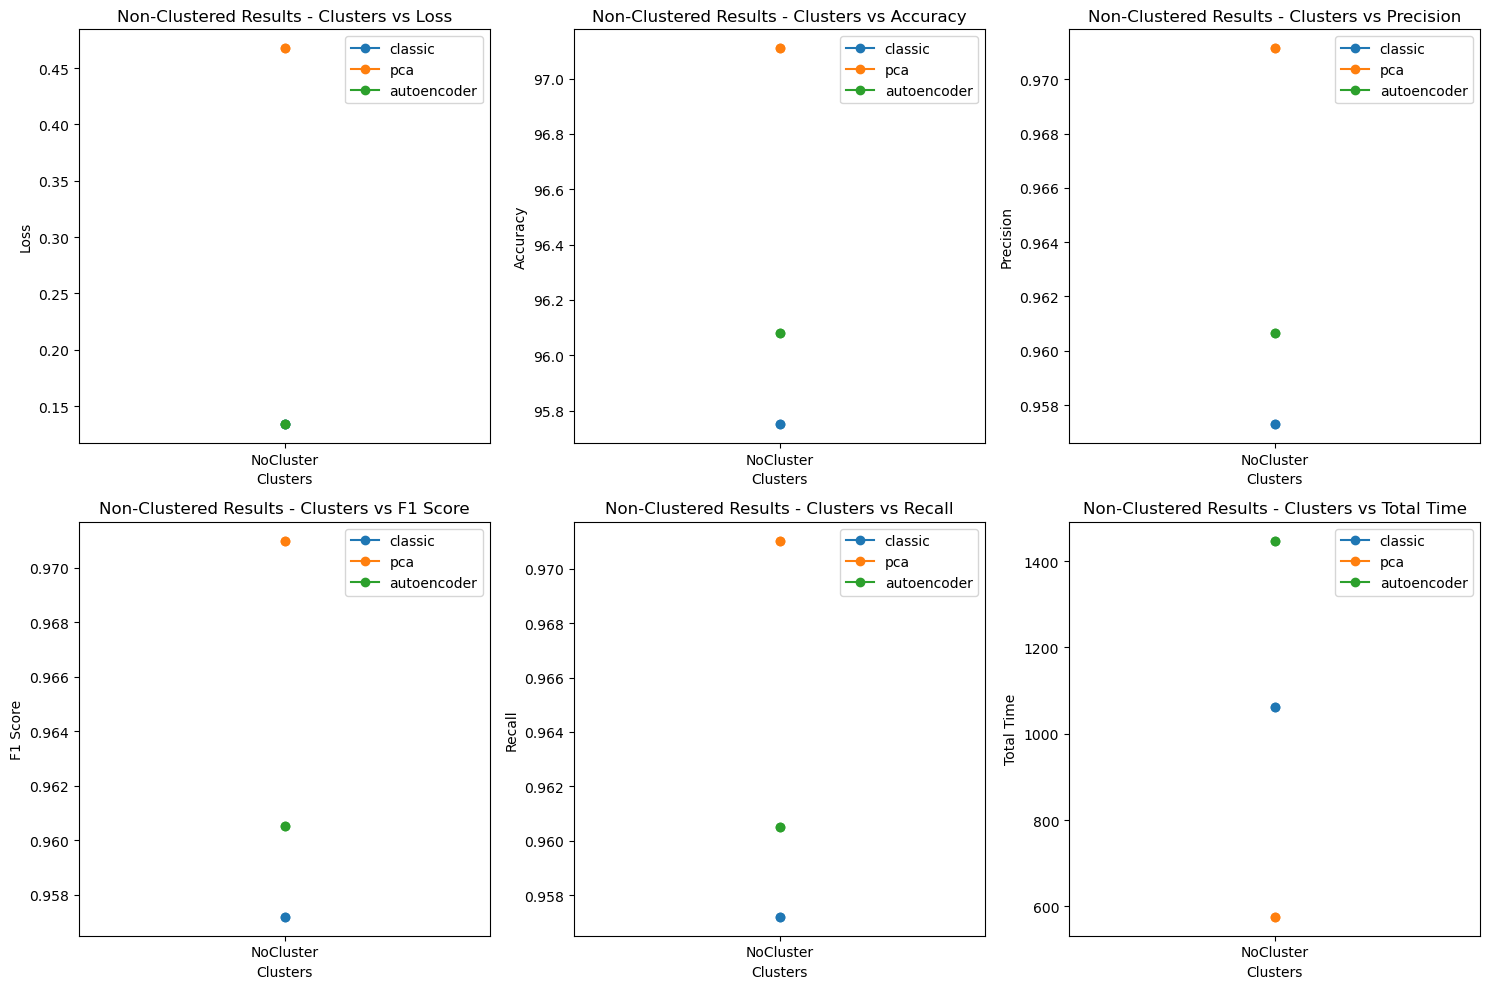


Clustered Results:
classic:
  Final Loss: {2: 0.04812007923126221, 4: 0.03998064956665039, 6: 0.03699978065490723, 8: 0.03528419437408447, 10: 0.034536015129089354}
  Final Accuracy: {2: 98.42, 4: 98.8, 6: 98.87, 8: 98.89, 10: 98.94}
  Final Precision: {2: 0.9842089101610426, 4: 0.9880000010020872, 6: 0.9887333015904402, 8: 0.9888855696260436, 10: 0.9894312580808858}
  Final F1 Score: {2: 0.9841343753151188, 4: 0.9879441458631092, 6: 0.9886442047858187, 8: 0.9888319444366533, 10: 0.9893627971858778}
  Final Recall: {2: 0.9841031264798271, 4: 0.9879145452620067, 6: 0.9885926869808541, 8: 0.9888111509906045, 10: 0.9893276513329836}
  Total Time: {2: 1042.5415015220642, 4: 1147.8886759281158, 6: 1127.9194297790527, 8: 1125.7170586585999, 10: 1152.615125656128}
pca:
  Final Loss: {2: 0.25686016845703125, 4: 0.20505394287109374, 6: 0.19606947479248046, 8: 0.17883182830810546, 10: 0.1794867645263672}
  Final Accuracy: {2: 98.01, 4: 98.16, 6: 98.11, 8: 98.18, 10: 98.17}
  Final Precision: {2

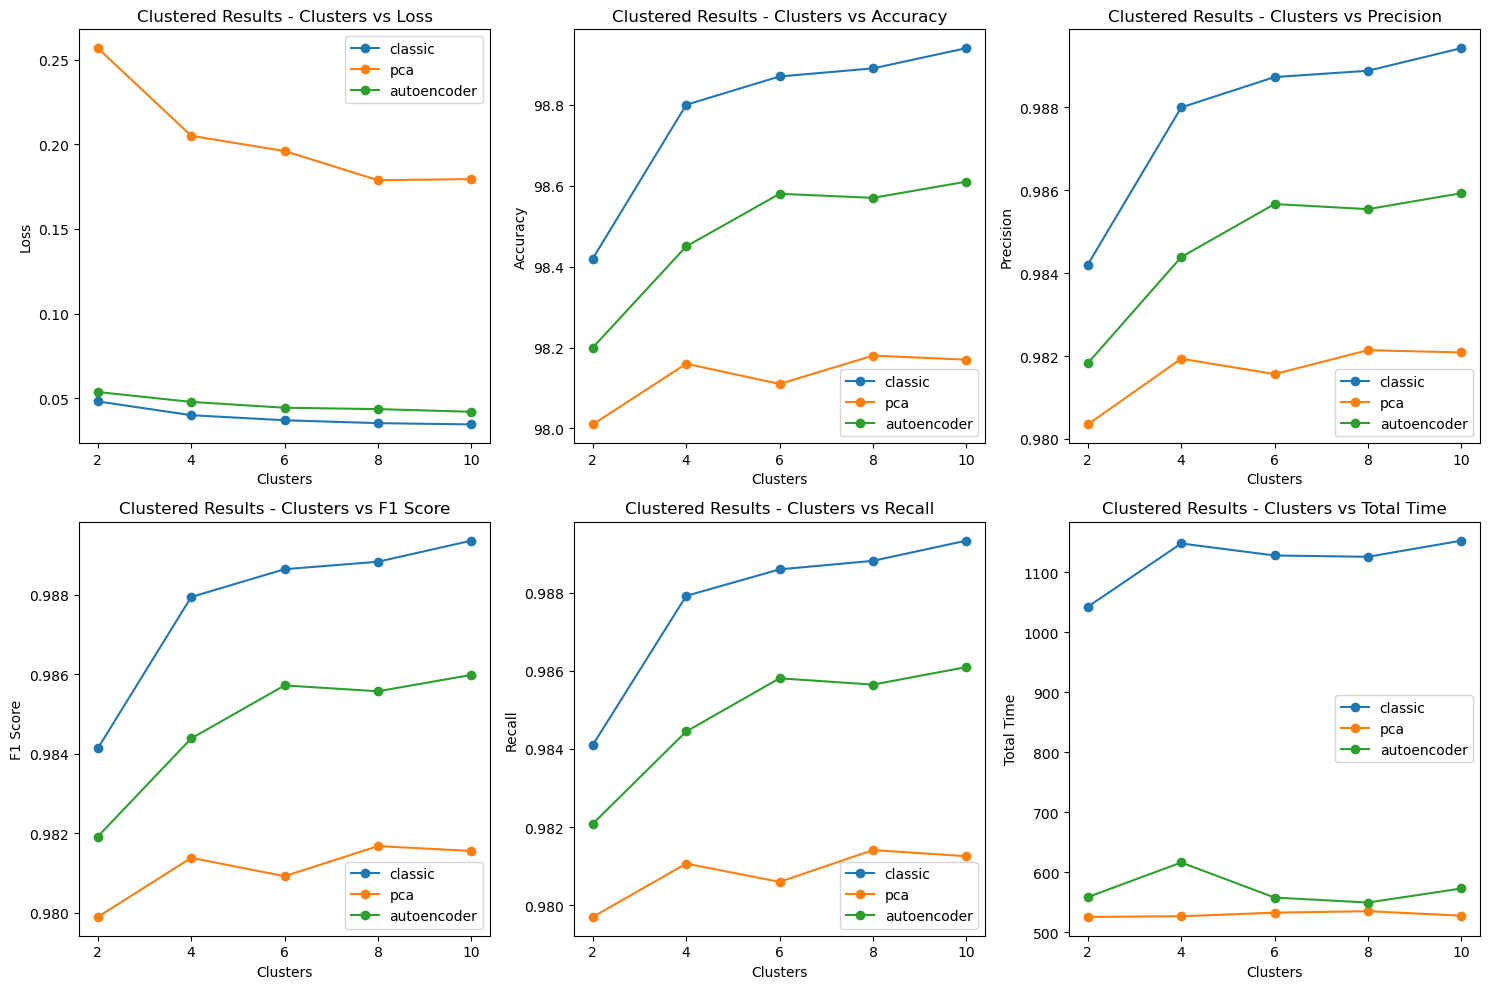

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute final metrics
def compute_final_metrics(metrics):
    final_loss = {alpha: data['losses'][-1] for alpha, data in metrics.items()}
    final_accuracy = {alpha: data['accuracy'][-1] for alpha, data in metrics.items()}
    final_precision = {alpha: data['precision'][-1] for alpha, data in metrics.items()}
    final_f1 = {alpha: data['f1'][-1] for alpha, data in metrics.items()}
    final_recall = {alpha: data['recall'][-1] for alpha, data in metrics.items()}

    # Sum of all training times
    total_time = {
        alpha: sum(data.get('TrainingTime', data.get('trainingTime', [0])))
        for alpha, data in metrics.items()
    }

    return final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time

# Function to print results
def print_results(results, title):
    print(f"\n{title}:")
    for method in results.keys():
        final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time = compute_final_metrics(results[method])
        print(f"{method}:")
        print("  Final Loss:", final_loss)
        print("  Final Accuracy:", final_accuracy)
        print("  Final Precision:", final_precision)
        print("  Final F1 Score:", final_f1)
        print("  Final Recall:", final_recall)
        print("  Total Time:", total_time)

# Function to plot the results
def plot_results(results, title, filename):
    plt.figure(figsize=(15, 10))

    # List of metrics to plot
    metrics_names = ["Loss", "Accuracy", "Precision", "F1 Score", "Recall", "Total Time"]
    for i, metric in enumerate(metrics_names):
        plt.subplot(2, 3, i + 1)

        # Plotting each method's metrics
        for method in results.keys():
            final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time = compute_final_metrics(results[method])

            # Select the right metric based on the iteration
            metric_values = {
                "Loss": final_loss,
                "Accuracy": final_accuracy,
                "Precision": final_precision,
                "F1 Score": final_f1,
                "Recall": final_recall,
                "Total Time": total_time
            }[metric]

            # Plot the metric values for each method
            plt.plot(list(metric_values.keys()) + ['NoCluster'], list(metric_values.values()) + [metric_values.get('NoCluster', np.nan)], marker='o', label=method)

        plt.xlabel('Clusters')
        plt.ylabel(metric)
        plt.title(f'{title} - Clusters vs {metric}')
        plt.legend()

    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Assuming 'results' and 'clusteredResults' are the data for the methods
# Print and plot results for non-clustered and clustered data

print_results(results, "Non-Clustered Results")
plot_results(results, "Non-Clustered Results", "non_clustered_results.png")

print_results(clusteredResults, "Clustered Results")
plot_results(clusteredResults, "Clustered Results", "clustered_results.png")
